# Здесь описать цели работы, гипотезу и идеи

In [251]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt

# data have many ';' and ','
csv_delimiter = '::'
# indicators to analysis
indicators = [
    'NY.GDP.MKTP.CD',       # GDP (current $)
    'NY.GDP.PCAP.KD',       # GDP per capita (constant 2015 $)
    'FP.CPI.TOTL.ZG',       # Inflation, consumer prices (annual %)
    'SL.UEM.TOTL.ZS',       # Unemployment, total (% of total labor force) (modeled ILO estimate)
    'DXGSRMRCHNSCD',        # Exports Merchandise, Customs, current US$, millions, not seas. adj.
    'DMGSRMRCHNSCD',        # Imports Merchandise, Customs, current US$, millions, not seas. adj.

    "TX.VAL.TECH.CD",       # High-technology exports (current US$)

    'SP.DYN.CDRT.IN',       # Death rate
]

def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open('indicators.csv', 'wt') as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv("indicators.csv", delimiter=csv_delimiter, engine='python')
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]['id']
    df = pd.DataFrame(columns=['country', 'date'])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, 'wt') as csv_file:
                name = data[1][0]["indicator"]["value"]
                print('country', 'date', name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)
        
        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine='python')
        # drop empty rows
        new.dropna(how='any', inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how='outer', on=('country', 'date'))

    return df

In [252]:
# download_indicators_list()
raw_df = get_indicators_data(indicators)

NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded
FP.CPI.TOTL.ZG is already loaded
SL.UEM.TOTL.ZS is already loaded
DXGSRMRCHNSCD is already loaded
DMGSRMRCHNSCD is already loaded
SP.DYN.CDRT.IN is already loaded


In [253]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17795 entries, 0 to 17794
Data columns (total 10 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   country                                                              17795 non-null  object 
 1   date                                                                 17795 non-null  int64  
 2   GDP (current US$)                                                    13979 non-null  float64
 3   GDP per capita (constant 2015 US$)                                   13963 non-null  float64
 4   Inflation, consumer prices (annual %)                                11004 non-null  float64
 5   Unemployment, total (% of total labor force) (modeled ILO estimate)  7752 non-null   float64
 6   Exports Merchandise, Customs, current US$, millions, not seas. adj.  4345 non-null   float64
 7   Impo

# Переименование столбцов

In [254]:
replace_rules = {
    'GDP (current US$)': 'GDP',
    'GDP per capita (constant 2015 US$)': 'GDP per capita',
    'Inflation, consumer prices (annual %)': 'inflation',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'unemployment',
    'Exports Merchandise, Customs, current US$, millions, not seas. adj.': 'merchandise exports',
    'Imports Merchandise, Customs, current US$, millions, not seas. adj.': 'imports merchandise',
    "High-technology exports (current US$)": 'high-technology exports',
    'Death rate, crude (per 1,000 people)': 'death rate',

    }

for a, b in replace_rules.items():
    if a in raw_df.columns:
        raw_df[b] = raw_df[a]
        raw_df.drop(columns=[a], inplace=True)

In [255]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17795 entries, 0 to 17794
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  17795 non-null  object 
 1   date                     17795 non-null  int64  
 2   GDP                      13979 non-null  float64
 3   GDP per capita           13963 non-null  float64
 4   inflation                11004 non-null  float64
 5   unemployment             7752 non-null   float64
 6   merchandise exports      4345 non-null   float64
 7   imports merchandise      4219 non-null   float64
 8   high-technology exports  2771 non-null   float64
 9   death rate               16282 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.4+ MB


# Отбор стран для анализа

In [256]:
# regions to take into statistics
include_regions = np.array([
       'Afghanistan', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji',
       'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland',
       'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq',
       'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati',
       "Korea, Dem. People's Rep.", 'Korea, Rep.', 'Kosovo', 'Kuwait',
       'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macao SAR, China', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives',
       'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius',
       'Mexico', 'Micronesia, Fed. Sts.', 'Moldova', 'Monaco', 'Mongolia',
       'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia',
       'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia',
       'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Romania',
       'Russian Federation', 'Rwanda', 'Samoa', 'San Marino',
       'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Seychelles', 'Sierra Leone', 'Singapore',
       'Sint Maarten (Dutch part)', 'Slovak Republic', 'Slovenia',
       'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan',
       'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Martin (French part)', 'St. Vincent and the Grenadines',
       'Sudan', 'Suriname', 'Sweden', 'Switzerland',
       'Syrian Arab Republic', 'Tajikistan', 'Tanzania', 'Thailand',
       'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia',
       'Turkiye', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu',
       'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, RB', 'Viet Nam', 'Virgin Islands (U.S.)',
       'West Bank and Gaza', 'Yemen, Rep.', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [257]:
# dataset of needed countries
cleared_df = raw_df[raw_df["country"].isin(include_regions)]

# countries in each group
N = 9
# years to analyze (including edges)
start_year = 1995
end_year = 2020

# arrange by last available year
top_absolute_GDP_countries = cleared_df[cleared_df["date"] == 2023].sort_values(    # group 1
    "GDP", ascending=False
)[:N]["country"].reset_index(drop=True)
top_GDP_per_capita_countries = cleared_df[cleared_df["date"] == 2023].sort_values(  # group 2
    "GDP per capita", ascending=False
)[:N]["country"].reset_index(drop=True)

In [258]:
print(
    f"Top {N} countries by GDP (group 1):",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite (group 2):",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 9 countries by GDP (group 1):
0     United States
1             China
2           Germany
3             Japan
4             India
5    United Kingdom
6            France
7             Italy
8            Brazil
Name: country, dtype: object
Top 9 countries by GDP per capite (group 2):
0       Luxembourg
1          Ireland
2      Switzerland
3           Norway
4        Singapore
5    United States
6        Australia
7          Denmark
8          Iceland
Name: country, dtype: object


In [259]:
# create new dataframe with choosed countries
df = cleared_df[cleared_df['country'].isin(pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries]))][cleared_df['date'] >= start_year][cleared_df['date'] <= end_year].sort_values('date', ascending=True)
df['group'] = df['country'].isin(top_GDP_per_capita_countries) + 1

#################### hotfix if country is in both lists simultaneously
to_duplicate = df[df['country'].isin(top_absolute_GDP_countries)][df['country'].isin(top_GDP_per_capita_countries)]
to_duplicate['group'] = 1
df = pd.concat([df, to_duplicate])

C:\Users\redun\AppData\Local\Temp\ipykernel_54228\2531308194.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[cleared_df['country'].isin(pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries]))][cleared_df['date'] >= start_year][cleared_df['date'] <= end_year].sort_values('date', ascending=True)
C:\Users\redun\AppData\Local\Temp\ipykernel_54228\2531308194.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[cleared_df['country'].isin(pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries]))][cleared_df['date'] >= start_year][cleared_df['date'] <= end_year].sort_values('date', ascending=True)
C:\Users\redun\AppData\Local\Temp\ipykernel_54228\2531308194.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_duplicate = df[df['country'].isin(top_absolute_GDP_countries)][df['country'].isin(top_GDP_per_capita_countries)]


In [260]:
df

,country,date,GDP,GDP per capita,inflation,unemployment,merchandise exports,imports merchandise,high-technology exports,death rate,group
13496,United States,1995,7.639749e+12,41710.820725,2.805420,5.650,584740.4,7.435450e+05,NaN,8.800,2
7943,Japan,1995,5.545564e+12,30171.163792,-0.127899,3.150,442918.0,3.360551e+05,NaN,7.400,1
3253,Australia,1995,3.681660e+11,39309.994665,4.627767,8.473,53087.0,5.740456e+04,NaN,6.900,2
13432,United Kingdom,1995,1.344240e+12,33009.304151,2.697495,8.694,153893.0,2.979330e+05,NaN,11.100,1
4876,China,1995,7.344848e+11,1520.029469,16.791225,3.000,148779.0,1.320854e+05,NaN,6.570,1
...,...,...,...,...,...,...,...,...,...,...,...
13475,United States,2016,1.880491e+13,57658.670883,1.261583,4.869,1451459.8,2.186786e+06,1.739217e+11,8.493,1
13474,United States,2017,1.961210e+13,58703.144078,2.130110,4.355,1547195.5,2.339591e+06,1.545450e+11,8.638,1
13473,United States,2018,2.065652e+13,60127.210278,2.442583,3.896,1665786.8,2.536145e+06,1.538085e+11,8.678,1
13472,United States,2019,2.152140e+13,61330.645977,1.812210,3.669,1645940.4,2.491699e+06,1.539235e+11,8.697,1


In [261]:
from matplotlib import colormaps

# generator object returning different colors
def color_gen_f():
    val = 0
    colors_n = 10
    step = 1
    cmap = colormaps.get_cmap('tab10')
    while True:
        yield cmap(val / colors_n)
        val = (val + step) % colors_n

color_gen = color_gen_f()

# Графики ВВП по отобранным странам

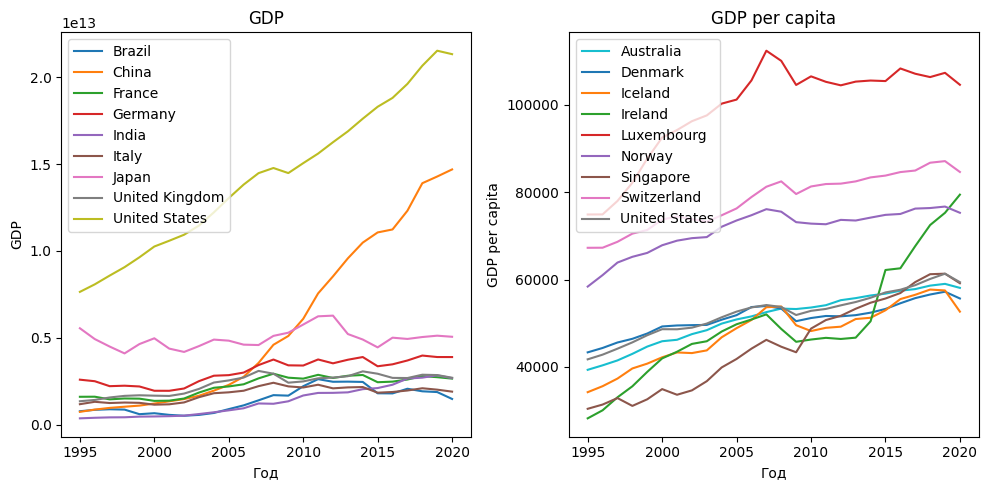

In [262]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP", "GDP per capita"]

for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df['group'] == i + 1].groupby(['country']):
        axis = series.plot(x='date', y=attributes[i], label=country[0], xlabel='Год', ylabel=attributes[i], ax=axis, color=next(color_gen))

plt.tight_layout()
plt.show()

# Макроэкономика
### Инфляция и безработица

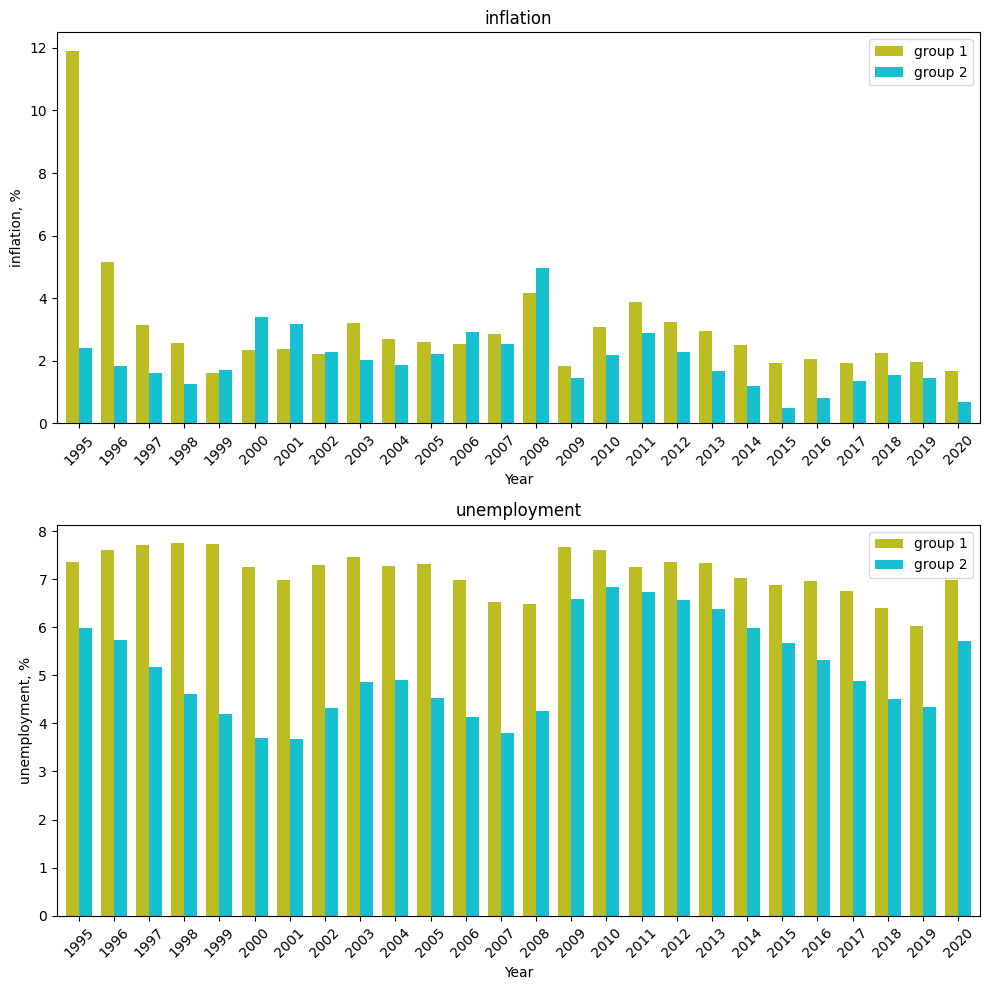

In [263]:
fig = plt.figure("Inflation and unemployment", figsize=(10, 10))

attributes = ["inflation", "unemployment"]
colors = [next(color_gen) for i in range(2)]


for i in range(2):
    axis = plt.subplot(2, 1, i + 1)
    plt.title(attributes[i])

    means = (
        df.groupby(["date", "group"])
        .aggregate({attributes[i]: "mean"})
        .unstack(level=1)
    )
    axis = means.plot(
        kind="bar",
        ylabel=attributes[i] + ", %",
        rot=45,
        xlabel="Year",
        ax=axis,
        color=colors,
        width=0.74
    )
    plt.legend(labels=['group 1', 'group 2'])

plt.tight_layout()
plt.show()

### Выводы об инфляции и безработице
## Анализ торговли

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 13496 to 13471
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  468 non-null    object 
 1   date                     468 non-null    int64  
 2   GDP                      468 non-null    float64
 3   GDP per capita           468 non-null    float64
 4   inflation                468 non-null    float64
 5   unemployment             468 non-null    float64
 6   merchandise exports      468 non-null    float64
 7   imports merchandise      460 non-null    float64
 8   high-technology exports  250 non-null    float64
 9   death rate               468 non-null    float64
 10  group                    468 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 43.9+ KB


In [265]:
# convert absolute values (millions US$ to relative (% of GDP))
df["merchandise exports"] = df["merchandise exports"] * 1_000_000 / df["GDP"] * 100
df["imports merchandise"] = df["imports merchandise"] * 1_000_000 / df["GDP"] * 100


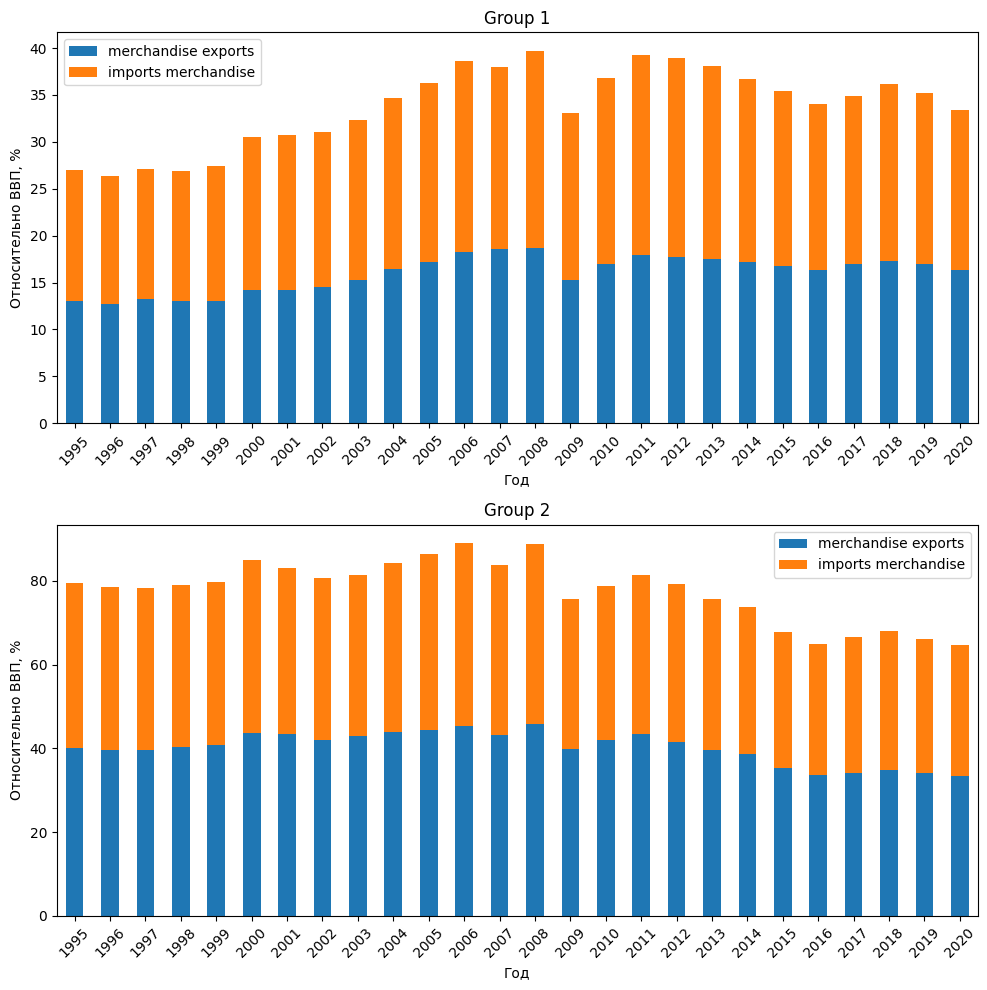

In [266]:
fig = plt.figure("Merchandise trade", figsize=(10, 10))

attributes = ["merchandise exports", "imports merchandise"]
colors = [next(color_gen) for i in range(len(attributes))]

# plt.title("Merchandise")

# get mean values for each group
for i in range(2):
    axis = plt.subplot(2, 1, i + 1)
    plt.title(f"Group {i + 1}")
    means = (
        df[df["group"] == i + 1]
        .groupby(["date"])
        .aggregate({attr: "mean" for attr in attributes})
        .reset_index()
    )

    means.plot(
        kind="bar",
        stacked=True,
        x="date",
        y=attributes,
        rot=45,
        xlabel="Год",
        ylabel="Относительно ВВП, %",
        ax=axis,
        color=colors,
    )
    # means.plot(kind='bar', x='date', y=attributes[1], rot=45, xlabel='Год', ylabel='Доля ВВП, %', ax=axis, color=colors[1])

plt.tight_layout()
plt.show()

## Доля экспорта высоких технологий в ВВП

In [267]:
# convert absolute values (US$ to relative (% of GDP))
df["high-technology exports"] = df["high-technology exports"] / df["GDP"] * 100

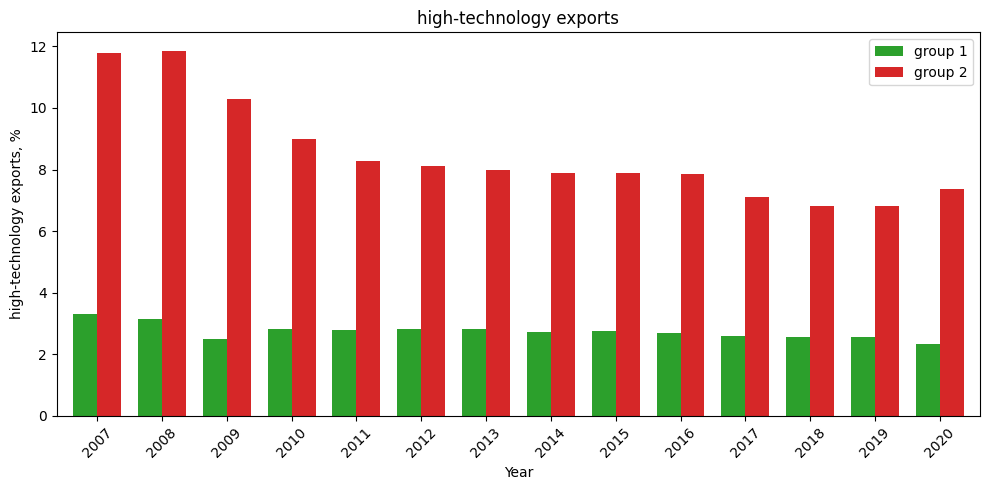

In [275]:
fig = plt.figure("High-technology exports", figsize=(10, 5))

attributes = ["high-technology exports"]
colors = [next(color_gen) for i in range(2)]


axis = plt.subplot(1, 1, 1)
plt.title(attributes[0])

means = (
    df[df['date'] >= 2007]          # available only from 2007
    .groupby(["date", "group"])
    .aggregate({attributes[0]: "mean"})
    .unstack(level=1)
)
axis = means.plot(
    kind="bar",
    ylabel=attributes[0] + ", %",
    rot=45,
    xlabel="Year",
    ax=axis,
    color=colors,
    width=0.74
)
plt.legend(labels=['group 1', 'group 2'])

plt.tight_layout()
plt.show()